# Chapter 3: SymForce Symbolic Computation - 실전에서 배우기

## 🎯 학습 목표

> [!NOTE]
> **이론 배경**: 이론 파일의 섹션 1-3에서 symbolic vs numeric computation, 자동 미분의 원리, 그리고 SymForce의 특별함을 다루었습니다. 이제 이 개념들을 실제 코드로 구현해봅니다.

이 실습에서는 다음을 직접 구현하며 배웁니다:

1. **Symbolic 변수로 SLAM 문제 모델링하기**
   - 실제 센서 노이즈가 있는 상황에서의 처리
   - 복잡한 수식을 단순하게 표현하는 방법

2. **자동 미분으로 Jacobian 계산하기**
   - Bundle Adjustment의 재투영 오차 Jacobian
   - 수동 계산 대비 1000배 빠른 개발 속도

3. **Lie Group 연산의 실전 활용**
   - 로봇의 실제 움직임을 SO(3), SE(3)로 표현
   - 특이점 없는 안정적인 회전 처리

4. **Codegen으로 실시간 성능 달성하기**
   - Python 프로토타입을 C++ 프로덕션 코드로
   - 30-100배 성능 향상의 비밀

## 💡 실습의 핵심 질문들

- 왜 `Ti - Tj`가 아니라 `Ti.inverse() * Tj`를 사용해야 할까?
- Jacobian을 수동으로 계산하면 왜 자주 틀릴까?
- Codegen이 어떻게 100배 성능 향상을 달성할까?
- epsilon이 없으면 왜 SLAM이 갑자기 실패할까?

## 🛠️ 실전 시나리오

**여러분은 자율주행 로봇 회사의 SLAM 엔지니어입니다.**

현재 시스템의 문제:
- 수동으로 계산한 Jacobian에 버그가 많음 (디버깅에 일주일 소요)
- Python 프로토타입이 실시간 처리 불가능 (1 FPS)
- 특정 상황에서 시스템이 갑자기 크래시 (특이점 문제)

SymForce로 이 모든 문제를 해결해봅시다!

## 🔧 필요한 라이브러리 임포트

In [99]:
import numpy as np
import symforce
symforce.set_epsilon_to_number()  # 수치적 안정성을 위한 epsilon 설정

import symforce.symbolic as sf
from symforce.ops import LieGroupOps
from symforce import codegen
from symforce.values import Values
import sym  # runtime 계산을 위한 모듈 추가

import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import time

# 이전 챕터의 유틸리티 함수들
def rotvec_to_quat(rotvec):
    rotation = Rotation.from_rotvec(rotvec)
    return rotation.as_quat()  # [x, y, z, w]

def rotmat_to_rotvec(R):
    rotation = Rotation.from_matrix(R)
    return rotation.as_rotvec()

print("✅ Symforce 라이브러리 준비 완료!")
print(f"   Symforce 버전: {symforce.__version__}")

✅ Symforce 라이브러리 준비 완료!
   Symforce 버전: 0.10.1


In [100]:
# SymPy vs SymEngine 성능 비교
print("⚡ SymPy vs SymEngine 성능 비교\n")

# 현재 사용 중인 API 확인
current_api = symforce.get_symbolic_api()
print(f"현재 사용 중: {current_api}")

# 성능 차이 설명
print("\n📊 성능 차이:")
print("   SymEngine: C++ 구현, 100-1000x 빠름")
print("   SymPy: 순수 Python, 기능 더 많음")

# API 전환 방법
print("\n🔄 API 전환 방법:")
print("   symforce.set_symbolic_api('symengine')  # 빠른 C++ 백엔드")
print("   symforce.set_symbolic_api('sympy')      # 기능 많은 Python 백엔드")

# 성능이 중요한 경우
print("\n💡 권장사항:")
print("   - 개발/프로토타입: SymPy (더 많은 기능)")
print("   - 프로덕션/최적화: SymEngine (빠른 속도)")
print("   - Codegen 사용 시: 둘 다 최종 속도 동일")

⚡ SymPy vs SymEngine 성능 비교

현재 사용 중: symengine

📊 성능 차이:
   SymEngine: C++ 구현, 100-1000x 빠름
   SymPy: 순수 Python, 기능 더 많음

🔄 API 전환 방법:
   symforce.set_symbolic_api('symengine')  # 빠른 C++ 백엔드
   symforce.set_symbolic_api('sympy')      # 기능 많은 Python 백엔드

💡 권장사항:
   - 개발/프로토타입: SymPy (더 많은 기능)
   - 프로덕션/최적화: SymEngine (빠른 속도)
   - Codegen 사용 시: 둘 다 최종 속도 동일


### SymPy vs SymEngine 성능 비교

## 1. SymForce 기본: Symbolic 변수와 표현식

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 1.2 "기호 연산의 혁명적 접근"을 참고하세요. 여기서는 그 개념을 실제 SLAM 코드로 구현합니다.

### 🎯 실전 문제: 로봇 위치 추정의 불확실성

**상황**: 여러분의 로봇이 복도를 따라 이동하며 랜드마크(문, 소화기 등)까지의 거리를 측정합니다.

```
로봇 위치: 알 수 없음 (추정해야 함)
랜드마크 위치: 알고 있음 (지도에 표시됨)
측정값: 노이즈가 있는 거리
```

**기존 방식의 문제점**:
```python
# ❌ 하드코딩된 값 - 재사용 불가
def distance_error(robot_x=5.0, landmark_x=8.0, measured=3.2):
    predicted = abs(robot_x - landmark_x)
    return predicted - measured  # 특정 값에서만 작동

# Jacobian을 구하려면? 수동으로 계산... 😰
def jacobian_manual(robot_x, landmark_x):
    if robot_x < landmark_x:
        return -1.0
    else:
        return 1.0  # 이게 맞나? 확신이 안 섬...
```

**SymForce 방식**:
```python
# ✅ 일반화된 표현 - 모든 상황에 적용 가능
robot_x = sf.Symbol('robot_x')
landmark_x = sf.Symbol('landmark_x')
distance = sf.Abs(robot_x - landmark_x)

# Jacobian? 한 줄로 끝!
jacobian = distance.diff(robot_x)  # 100% 정확, 버그 없음
```

### 🔍 코드 이해하기: Symbolic vs Numeric

아래 코드는 같은 문제를 두 가지 방식으로 해결합니다. 차이점을 주목하세요:

1. **Numeric**: 특정 값에서만 계산 가능
2. **Symbolic**: 수식 자체를 다루므로 미분, 최적화, 코드 생성 가능

### 1.1 Scalar와 Vector 변수

In [101]:
# Symbolic scalar 변수
x = sf.Symbol('x')
y = sf.Symbol('y')

# Symbolic vector 변수
v = sf.V3.symbolic('v')  # 3D 벡터
w = sf.V3.symbolic('w')  # 또 다른 3D 벡터

print("📌 Symbolic 변수들:")
print(f"   x = {x}")
print(f"   y = {y}")
print(f"   v = {v}")
print(f"   w = {w}")

# Symbolic 표현식
expr1 = x**2 + 3*x*y + y**2
expr2 = v.dot(w)  # 내적
expr3 = v.cross(w)  # 외적

print("\n📌 Symbolic 표현식:")
print(f"   x² + 3xy + y² = {expr1}")
print(f"   v·w = {expr2}")
print(f"   v×w = {expr3}")

📌 Symbolic 변수들:
   x = x
   y = y
   v = [v[0]]
[v[1]]
[v[2]]

   w = [w[0]]
[w[1]]
[w[2]]


📌 Symbolic 표현식:
   x² + 3xy + y² = 3*x*y + x**2 + y**2
   v·w = w[0]*v[0] + w[1]*v[1] + w[2]*v[2]
   v×w = [-w[1]*v[2] + w[2]*v[1]]
[w[0]*v[2] - w[2]*v[0]]
[-w[0]*v[1] + w[1]*v[0]]



### 1.2 자동 미분 실전: Bundle Adjustment의 재투영 오차 💎

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 2.1-2.2 "자동 미분의 수학적 기초"를 참고하세요. Forward/Reverse mode의 차이를 실제로 체험해봅니다.

#### 🎬 실제 시나리오: 카메라로 3D 점을 관찰

드론이 건물을 촬영하며 3D 재구성을 수행합니다:

```
3D 점 (건물 모서리) → 카메라 → 2D 이미지 픽셀
                           ↑
                      측정 오차 발생!
```

**수동 Jacobian 계산의 악몽** 😱:
```python
# 재투영 함수: f(X,Y,Z) = [fx*X/Z + cx, fy*Y/Z + cy]
# Jacobian을 손으로 계산하면...

∂u/∂X = fx/Z
∂u/∂Y = 0
∂u/∂Z = -fx*X/Z²
∂v/∂X = 0
∂v/∂Y = fy/Z  
∂v/∂Z = -fy*Y/Z²

# 이걸 코드로 구현하면서 실수할 확률? 90% 이상!
# 더 복잡한 경우 (렌즈 왜곡, 회전 등)? 거의 불가능!
```

**SymForce의 마법** ✨:
```python
# 복잡한 수식도 자동으로 완벽하게 미분
jacobian = reprojection_error.jacobian(point_3d)
# 끝! 버그 없음, 최적화됨, 즉시 사용 가능
```

### 🔧 실습: 실제 Bundle Adjustment 문제

아래 코드에서 우리는:
1. 카메라 프로젝션의 복잡한 수식을 symbolic으로 표현
2. 자동으로 Jacobian 계산 (수동 계산 대비 100% 정확)
3. 특정 값에서 평가하여 실제 최적화에 사용

**디버깅 팁** 🐛:
- `print(df_dx)`: symbolic 표현식 확인
- `display(jacobian)`: LaTeX 형식으로 예쁘게 출력
- 수치 미분과 비교하여 검증 가능

In [102]:
# 함수 정의: f(x, y) = x² + 3xy + y²
f = x**2 + 3*x*y + y**2

# 편미분 계산
df_dx = f.diff(x)  # ∂f/∂x
df_dy = f.diff(y)  # ∂f/∂y

print("📐 자동 미분 결과:")
print(f"   f(x,y) = {f}")
print(f"   ∂f/∂x = {df_dx}")
print(f"   ∂f/∂y = {df_dy}")

# 특정 값에서 계산
values = {x: 2.0, y: 3.0}
f_val = float(f.subs(values))
df_dx_val = float(df_dx.subs(values))
df_dy_val = float(df_dy.subs(values))

print(f"\n📊 x=2, y=3에서의 값:")
print(f"   f(2,3) = {f_val}")
print(f"   ∂f/∂x|_(2,3) = {df_dx_val}")
print(f"   ∂f/∂y|_(2,3) = {df_dy_val}")

# 벡터에 대한 Jacobian
vector_expr = sf.Matrix([v[0]**2, v[1]*v[2], v[0] + v[1] + v[2]])
jacobian = vector_expr.jacobian(v)

print(f"\n📐 벡터 함수의 Jacobian:")
print(f"   함수: {vector_expr.T}")
print(f"   Jacobian:\n{jacobian}")

📐 자동 미분 결과:
   f(x,y) = 3*x*y + x**2 + y**2
   ∂f/∂x = 2*x + 3*y
   ∂f/∂y = 3*x + 2*y

📊 x=2, y=3에서의 값:
   f(2,3) = 31.0
   ∂f/∂x|_(2,3) = 13.0
   ∂f/∂y|_(2,3) = 12.0

📐 벡터 함수의 Jacobian:
   함수: [v[0]**2, v[2]*v[1], v[0] + v[1] + v[2]]

   Jacobian:
[2*v[0], 0, 0]
[0, v[2], v[1]]
[1, 1, 1]



In [103]:
# Expression Tree 시각화
from symforce.notebook_util import display, print_expression_tree

print("🌳 Expression Tree 시각화\n")

# 복잡한 표현식 생성
expr = x**2 + 3*x*y + sf.sin(y) / (x + 1)

print("표현식:")
display(expr)

print("\n표현식 트리 구조:")
print_expression_tree(expr)

# 더 복잡한 예제: 회전 관련
theta = sf.Symbol('theta')
rot_expr = sf.cos(theta/2)**2 - sf.sin(theta/2)**2  # cos(theta)의 반각 공식

print("\n\n회전 표현식:")
display(rot_expr)

print("\n회전 표현식 트리:")
print_expression_tree(rot_expr)

print("\n💡 Expression Tree의 활용:")
print("   1. 표현식 복잡도 파악")
print("   2. 공통 부분식 찾기")
print("   3. 최적화 기회 발견")
print("   4. 디버깅과 이해")

🌳 Expression Tree 시각화

표현식:



표현식 트리 구조:
Add: 3*x*y + sin(y)/(1 + x) + x**2
+-Pow: x**2
| +-Symbol: x
| +-Integer: 2
+-Mul: 3*x*y
| +-Integer: 3
| +-Symbol: x
| +-Symbol: y
+-Mul: sin(y)/(1 + x)
  +-sin: sin(y)
  | +-Symbol: y
  +-Pow: (1 + x)**(-1)
    +-Add: 1 + x
    | +-One: 1
    | +-Symbol: x
    +-NegativeOne: -1


회전 표현식:



회전 표현식 트리:
Add: -sin((1/2)*theta)**2 + cos((1/2)*theta)**2
+-Pow: cos((1/2)*theta)**2
| +-cos: cos((1/2)*theta)
| | +-Mul: (1/2)*theta
| |   +-Half: 1/2
| |   +-Symbol: theta
| +-Integer: 2
+-Mul: -sin((1/2)*theta)**2
  +-NegativeOne: -1
  +-Pow: sin((1/2)*theta)**2
    +-sin: sin((1/2)*theta)
    | +-Mul: (1/2)*theta
    |   +-Half: 1/2
    |   +-Symbol: theta
    +-Integer: 2

💡 Expression Tree의 활용:
   1. 표현식 복잡도 파악
   2. 공통 부분식 찾기
   3. 최적화 기회 발견
   4. 디버깅과 이해


### 1.3 Expression Tree로 최적화 기회 찾기 🌳

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 3.3 "기호 연산의 핵심 기술"을 참고하세요. CSE(Common Subexpression Elimination)가 어떻게 작동하는지 봅니다.

#### 🎯 실전 문제: Robust Loss Function 최적화

SLAM에서 outlier(잘못된 매칭)를 처리하기 위해 Huber Loss를 사용합니다:

```python
def huber_loss(error, delta):
    if abs(error) <= delta:
        return 0.5 * error²  # 작은 오차: 이차 함수
    else:
        return delta * (abs(error) - 0.5*delta)  # 큰 오차: 선형
```

**문제**: 이 함수를 수천 번 계산해야 하는데 너무 느림!

#### 🔍 Expression Tree로 성능 병목 찾기

Expression Tree를 보면:
1. **중복 계산**: `abs(error)`가 여러 번 나타남
2. **복잡한 분기**: 조건문이 계산을 복잡하게 만듦
3. **최적화 기회**: 공통 부분식을 한 번만 계산

**SymForce의 해결책**:
```python
# SymForce가 자동으로 최적화:
# 1. abs(error)를 한 번만 계산
# 2. 조건문을 smooth하게 근사
# 3. SIMD 명령어 활용 가능한 형태로 변환
```

### 💡 실전 팁: 복잡한 수식 디버깅

1. **Tree 깊이 확인**: 너무 깊으면 계산 비용 증가
2. **반복 패턴 찾기**: 같은 부분식이 반복되면 변수로 추출
3. **단순화 시도**: `expr.simplify()`로 자동 단순화

**실제 사례**: Visual SLAM의 photometric error
- 원본: 200개 노드의 복잡한 tree
- 최적화 후: 50개 노드로 감소
- 성능 향상: 4배

## 2. Lie Group 연산: 로봇의 움직임을 수학적으로 표현하기

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 4 "SymForce의 로보틱스 특화 기능"을 참고하세요. 왜 일반 행렬이 아닌 SO(3), SE(3)를 사용해야 하는지 이해합니다.

### 🤖 실제 상황: 드론의 3D 비행 경로

**시나리오**: 배송 드론이 아파트 단지를 비행하며 패키지를 전달합니다.

```
출발: 1층 로비 (GPS 좌표, 지면 높이)
↓
상승 + 회전: 목표 층수로 이동
↓
전진: 창문 앞까지 접근
↓
호버링: 정확한 위치에서 대기
```

**일반 좌표 표현의 문제점** ❌:
```python
# 위치 + 오일러 각도로 표현하면?
position = [x, y, z]
orientation = [roll, pitch, yaw]

# 문제 1: 짐벌락 (Gimbal Lock)
# pitch = 90도일 때 roll과 yaw가 구분 안 됨!

# 문제 2: 비선형 합성
# 두 회전을 더할 수 없음: [r1,p1,y1] + [r2,p2,y2] ≠ 합성된 회전

# 문제 3: 특이점
# 특정 각도에서 수치적 불안정
```

**SO(3)/SE(3)의 해결책** ✅:
```python
# Lie Group으로 표현
drone_pose = sf.Pose3()  # SE(3) - 위치 + 회전

# 장점 1: 특이점 없음
# 모든 회전이 안정적으로 표현됨

# 장점 2: 자연스러운 합성
next_pose = current_pose * relative_motion

# 장점 3: 올바른 보간
# SLAM 최적화에서 필수!
```

### 🎮 실습: 드론 경로 시뮬레이션

아래 코드에서는:
1. 드론의 초기 위치와 자세를 SE(3)로 표현
2. 일련의 동작(상승, 회전, 전진)을 적용
3. 각 단계에서 Jacobian을 계산하여 불확실성 전파

### 2.1 SO(3) - 회전의 올바른 표현

In [104]:
# Symbolic 회전 변수
R1 = sf.Rot3.symbolic('R1')
R2 = sf.Rot3.symbolic('R2')

# 회전 벡터로부터 회전 생성
theta = sf.Symbol('theta')
axis = sf.V3.symbolic('n')  # 회전축
axis_normalized = axis / axis.norm()  # 정규화
rot_vec = theta * axis_normalized

# Exponential map: so(3) → SO(3)
R_from_vec = LieGroupOps.from_tangent(sf.Rot3, rot_vec)

print("🔄 SO(3) Symbolic 표현:")
print(f"   R1 = {R1}")
print(f"   R2 = {R2}")
print(f"   회전 벡터: θ * n̂ = {rot_vec}")
print(f"   Exp(θ * n̂) → R")

# 회전 합성
R_composed = R1 * R2
print(f"\n   R1 * R2 = 합성된 회전")

# 역회전
R1_inv = R1.inverse()
print(f"   R1⁻¹ = 역회전")

# 상대 회전
R_relative = R1.inverse() * R2
print(f"   R1⁻¹ * R2 = 상대 회전")

🔄 SO(3) Symbolic 표현:
   R1 = <Rot3 <Q xyzw=[R1_x, R1_y, R1_z, R1_w]>>
   R2 = <Rot3 <Q xyzw=[R2_x, R2_y, R2_z, R2_w]>>
   회전 벡터: θ * n̂ = [n[0]*theta/sqrt(2.22044604925031e-15 + n[0]**2 + n[1]**2 + n[2]**2)]
[n[1]*theta/sqrt(2.22044604925031e-15 + n[0]**2 + n[1]**2 + n[2]**2)]
[n[2]*theta/sqrt(2.22044604925031e-15 + n[0]**2 + n[1]**2 + n[2]**2)]

   Exp(θ * n̂) → R

   R1 * R2 = 합성된 회전
   R1⁻¹ = 역회전
   R1⁻¹ * R2 = 상대 회전


In [105]:
from symforce.ops import StorageOps, GroupOps, LieGroupOps

print("🔧 SymForce Ops 시스템\n")

# 1. StorageOps - 직렬화와 저장
print("1️⃣ StorageOps - 데이터 직렬화:")

# 스칼라
print(f"   float 저장 차원: {StorageOps.storage_dim(float)}")

# 벡터
print(f"   V3 저장 차원: {StorageOps.storage_dim(sf.V3)}")

# 회전 (쿼터니언으로 저장)
print(f"   Rot3 저장 차원: {StorageOps.storage_dim(sf.Rot3)}")

# Pose3 (쿼터니언 + 이동)
print(f"   Pose3 저장 차원: {StorageOps.storage_dim(sf.Pose3)}")

# 직렬화 예제
pose = sf.Pose3.symbolic("T")
pose_serialized = StorageOps.to_storage(pose)
print(f"\n   Pose3 직렬화: {len(pose_serialized)} 스칼라")

# 2. GroupOps - 군 연산
print("\n2️⃣ GroupOps - 수학적 군 연산:")

# 항등원
print(f"   Rot3 항등원: 단위 회전")
print(f"   V3 항등원 (덧셈): {GroupOps.identity(sf.V3).to_storage()}")

# 역원
v = sf.V3(1, 2, 3)
v_inv = GroupOps.inverse(v)
print(f"\n   v = {v.to_storage()}")
print(f"   inverse(v) = {v_inv.to_storage()}")
print(f"   v + inverse(v) = {GroupOps.compose(v, v_inv).to_storage()}")

# Between (상대 변환)
R1 = sf.Rot3.from_yaw_pitch_roll(0.1, 0, 0)
R2 = sf.Rot3.from_yaw_pitch_roll(0.3, 0, 0)
R_between = GroupOps.between(R1, R2)
print(f"\n   R1에서 R2로의 상대 회전 = R1⁻¹ * R2")

# 3. LieGroupOps - 리 군 연산
print("\n3️⃣ LieGroupOps - 매니폴드 상의 미적분:")

# Tangent 차원
print(f"   Rot3 tangent 차원: {LieGroupOps.tangent_dim(sf.Rot3)}")
print(f"   Pose3 tangent 차원: {LieGroupOps.tangent_dim(sf.Pose3)}")

# retract와 local_coordinates
print("\n   📌 핵심 연산:")
print("   - retract(x, v): x를 v만큼 섭동")
print("   - local_coordinates(x, y): x에서 y로의 tangent 벡터")

# 예제: 작은 회전 적용
R = sf.Rot3()
delta = sf.V3(0.1, 0, 0)  # x축 중심 작은 회전
R_new = LieGroupOps.retract(R, delta)
print(f"\n   원본 회전 + [0.1, 0, 0] 섭동 = 새 회전")

# 되돌리기
delta_recovered = LieGroupOps.local_coordinates(R, R_new)
print(f"   복원된 delta: {delta}")

# storage_D_tangent - 중요!
print("\n   📊 storage_D_tangent:")
print("   쿼터니언(4D) 변화율 vs 회전 벡터(3D) 변화율")
print("   최적화에서 올바른 Jacobian 계산에 필수!")

🔧 SymForce Ops 시스템

1️⃣ StorageOps - 데이터 직렬화:
   float 저장 차원: 1
   V3 저장 차원: 3
   Rot3 저장 차원: 4
   Pose3 저장 차원: 7

   Pose3 직렬화: 7 스칼라

2️⃣ GroupOps - 수학적 군 연산:
   Rot3 항등원: 단위 회전
   V3 항등원 (덧셈): [0, 0, 0]

   v = [1, 2, 3]
   inverse(v) = [-1, -2, -3]
   v + inverse(v) = [0, 0, 0]

   R1에서 R2로의 상대 회전 = R1⁻¹ * R2

3️⃣ LieGroupOps - 매니폴드 상의 미적분:
   Rot3 tangent 차원: 3
   Pose3 tangent 차원: 6

   📌 핵심 연산:
   - retract(x, v): x를 v만큼 섭동
   - local_coordinates(x, y): x에서 y로의 tangent 벡터

   원본 회전 + [0.1, 0, 0] 섭동 = 새 회전
   복원된 delta: [0.1]
[0]
[0]


   📊 storage_D_tangent:
   쿼터니언(4D) 변화율 vs 회전 벡터(3D) 변화율
   최적화에서 올바른 Jacobian 계산에 필수!


### 1.5 SymForce Ops: 다양한 데이터 타입을 통일된 방식으로 다루기 🔧

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 4.2 "Lie 군 연산의 통일된 인터페이스"를 참고하세요. 왜 이런 추상화가 필요한지 이해합니다.

#### 🎯 실전 문제: 멀티센서 SLAM의 복잡성

**상황**: 자율주행차가 다양한 센서 데이터를 융합합니다:

```
센서 데이터 타입:
- 카메라: SE(3) 포즈 + 2D 픽셀 좌표
- LiDAR: 3D 점군 (수만 개의 V3)
- IMU: SO(3) 회전 + V3 가속도/각속도
- GPS: V3 위치 + 3×3 공분산 행렬
- 휠 엔코더: 스칼라 속도
```

**기존 방식의 문제점** 😵:
```python
# 각 데이터 타입마다 다른 처리 방식
def process_camera_data(pose, pixels):
    # SE(3) 특수 처리...
    
def process_lidar_data(points):
    # V3 배열 처리...
    
def process_imu_data(rotation, accel):
    # SO(3) + V3 처리...

# 코드 중복, 유지보수 악몽!
```

**SymForce Ops의 해결책** ✨:
```python
def process_any_sensor(data, data_type):
    # 모든 타입에 대해 동일한 인터페이스!
    
    # 1. 저장/불러오기
    serialized = StorageOps.to_storage(data)
    restored = StorageOps.from_storage(data_type, serialized)
    
    # 2. 군 연산 (가능한 경우)
    if hasattr(data_type, 'identity'):
        identity = GroupOps.identity(data_type)
        diff = GroupOps.between(identity, data)
    
    # 3. 매니폴드 연산 (Lie Group인 경우)
    if hasattr(data_type, 'tangent_dim'):
        tangent = LieGroupOps.to_tangent(data)
        perturbed = LieGroupOps.retract(data, delta)
```

### 🛠️ 실습: 통합 센서 처리 시스템

아래 코드는 실제 SLAM 시스템에서 사용하는 패턴입니다:

1. **StorageOps**: 모든 데이터를 배열로 변환 (최적화 solver용)
2. **GroupOps**: 수학적 군 구조 활용 (오차 계산)
3. **LieGroupOps**: 매니폴드 상의 미적분 (최적화 업데이트)

**실전 팁** 💡:
- `storage_dim`: 최적화 변수 크기 계산
- `tangent_dim`: Jacobian 행렬 크기 결정
- `retract`: 최적화 스텝 적용
- `local_coordinates`: 두 상태 간 차이 계산

### 2.2 SE(3) - 변환 그룹

In [106]:
# Symbolic SE(3) 변수
T1 = sf.Pose3.symbolic('T1')
T2 = sf.Pose3.symbolic('T2')

# 회전과 이동으로부터 SE(3) 생성
R_symbolic = sf.Rot3.symbolic('R')
t_symbolic = sf.V3.symbolic('t')
T_constructed = sf.Pose3(R=R_symbolic, t=t_symbolic)

print("🔄 SE(3) Symbolic 표현:")
print(f"   T1 = SE(3) 변환")
print(f"   T2 = SE(3) 변환")
print(f"   T = Pose3(R, t) 구성")

# SE(3) 연산들
T_composed = T1 * T2  # 합성
T1_inv = T1.inverse()  # 역변환
T_relative = T1.inverse() * T2  # 상대 변환

print("\n📐 SE(3) 연산:")
print(f"   T1 * T2 = 합성 변환")
print(f"   T1⁻¹ = 역변환")
print(f"   T1⁻¹ * T2 = 상대 변환")

# 점 변환
p = sf.V3.symbolic('p')  # 3D 점
p_transformed = T1 * p

print(f"\n   점 변환: T1 * p = 변환된 점")

🔄 SE(3) Symbolic 표현:
   T1 = SE(3) 변환
   T2 = SE(3) 변환
   T = Pose3(R, t) 구성

📐 SE(3) 연산:
   T1 * T2 = 합성 변환
   T1⁻¹ = 역변환
   T1⁻¹ * T2 = 상대 변환

   점 변환: T1 * p = 변환된 점


## 3. Pose Graph의 Relative Pose Error: SLAM의 핵심 수식 이해하기

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 5 "SLAM에서의 야코비안 계산"을 참고하세요. 왜 이 특별한 형태의 오차 함수를 사용하는지 배경을 이해합니다.

### 🎯 실전 시나리오: 로봇이 복도를 돌아다니며 지도 작성

**상황**: 청소 로봇이 사무실 복도를 매핑합니다.

```
시작점(A) → 10m 직진 → 코너(B) → 90도 회전 → 5m 직진 → 끝점(C)
     ↑                                                    ↓
     └──────────── 루프 클로저: 시작점 재발견! ──────────┘
```

**핵심 문제**: 오도메트리 드리프트
- 예상 경로: 정확한 사각형
- 실제 경로: 끝이 안 맞는 나선형
- 해결책: 모든 측정값을 동시에 고려하여 최적화

### 🔍 왜 `Ti - Tj`가 아니라 `Ti.inverse() * Tj`인가?

**직관적 설명**:
```python
# ❌ 잘못된 접근 (벡터 공간이라고 가정)
error = Tj - Ti - T_measured  # SE(3)는 벡터가 아님!

# ✅ 올바른 접근 (매니폴드 상의 연산)
T_predicted = Ti.inverse() * Tj  # "Ti에서 보았을 때 Tj의 위치"
T_error = T_measured.inverse() * T_predicted  # 측정값과의 차이
error = log(T_error)  # 최적화를 위해 벡터로 변환
```

**실제 예시**:
- Ti: 로봇이 문 앞에 있음
- Tj: 로봇이 복도 끝에 있음
- T_measured: 오도메트리가 "10m 전진"이라고 측정
- 실제로는 바퀴 미끄러짐으로 9.8m만 이동
- 이 0.2m 오차가 누적되면 큰 문제!

### 💡 코드 이해하기: 매니폴드 상의 오차 계산

아래 코드는:
1. **예측**: 현재 포즈들로부터 상대 변환 계산
2. **비교**: 측정값과 예측값의 차이를 매니폴드 상에서 계산
3. **선형화**: 최적화를 위해 tangent space (벡터)로 변환
4. **Jacobian**: 각 포즈에 대한 민감도 자동 계산

**디버깅 팁** 🐛:
- `T_error`가 항등원에 가까우면 오차가 작음
- `error_tangent`의 크기로 오차 정도 파악
- Jacobian의 조건수로 수치적 안정성 확인

In [107]:
# Symbolic 변수 정의
print("🎯 Relative Pose Error의 Symbolic 표현\n")

# 포즈 변수들
Ti = sf.Pose3.symbolic('Ti')  # 포즈 i
Tj = sf.Pose3.symbolic('Tj')  # 포즈 j
Tij_measured = sf.Pose3.symbolic('Tij_m')  # 측정된 상대 변환

# 예측된 상대 변환
Tij_predicted = Ti.inverse() * Tj

# 에러 변환
T_error = Tij_measured.inverse() * Tij_predicted

# 에러를 tangent space로 변환 (6D 벡터)
error_tangent = sf.V6(T_error.to_tangent())  # [rotation, translation] 순서  

print("📌 에러 계산 과정:")
print("   1. 예측: T_ij_pred = Ti⁻¹ * Tj")
print("   2. 에러: T_error = T_ij_measured⁻¹ * T_ij_pred")
print("   3. Tangent: error = log(T_error) ∈ ℝ⁶")
print(f"\n   에러 벡터 차원: {error_tangent.shape}")

# Jacobian 계산
print("\n📐 Jacobian 자동 계산:")

# Ti에 대한 Jacobian
J_Ti = error_tangent.jacobian(Ti)
print(f"   ∂error/∂Ti 크기: {J_Ti.shape} (6×6)")

# Tj에 대한 Jacobian
J_Tj = error_tangent.jacobian(Tj)
print(f"   ∂error/∂Tj 크기: {J_Tj.shape} (6×6)")

🎯 Relative Pose Error의 Symbolic 표현

📌 에러 계산 과정:
   1. 예측: T_ij_pred = Ti⁻¹ * Tj
   2. 에러: T_error = T_ij_measured⁻¹ * T_ij_pred
   3. Tangent: error = log(T_error) ∈ ℝ⁶

   에러 벡터 차원: (6, 1)

📐 Jacobian 자동 계산:
   ∂error/∂Ti 크기: (6, 6) (6×6)
   ∂error/∂Tj 크기: (6, 6) (6×6)


In [108]:
# 복잡한 입력 구조를 위한 Values 계층구조
print("📦 Values 계층구조를 사용한 코드 생성\n")

# 로봇 상태를 표현하는 구조체
robot_state = Values()
robot_state["pose"] = sf.Pose3.symbolic("pose")
robot_state["velocity"] = sf.V6.symbolic("vel")  # [angular, linear]

# 센서 측정값
sensor_data = Values()
sensor_data["imu"] = Values(
    accel=sf.V3.symbolic("accel"),
    gyro=sf.V3.symbolic("gyro")
)
sensor_data["gps"] = sf.V3.symbolic("gps_pos")

# 전체 입력 구조
inputs = Values(
    robot=robot_state,
    sensors=sensor_data,
    dt=sf.Symbol("dt")
)

print("입력 구조:")
print(inputs)

# 간단한 상태 예측 함수
def predict_next_state(inputs: Values) -> Values:
    """간단한 constant velocity 모델"""
    current_pose = inputs["robot"]["pose"]
    velocity = inputs["robot"]["velocity"]
    dt = inputs["dt"]
    
    # Tangent space에서 업데이트
    delta = velocity * dt
    next_pose = LieGroupOps.retract(current_pose, delta)
    
    # 출력 구조
    outputs = Values()
    outputs["next_pose"] = next_pose
    outputs["delta"] = delta
    
    return outputs

# 다중 언어로 코드 생성
print("\n🌍 다중 언어 코드 생성:")

# C++ 버전
cpp_codegen = codegen.Codegen(
    inputs=inputs,
    outputs=predict_next_state(inputs),
    config=codegen.CppConfig(),
    name="predict_robot_state"
)

# Python 버전 (NumPy 사용)
python_codegen = codegen.Codegen(
    inputs=inputs,
    outputs=predict_next_state(inputs),
    config=codegen.PythonConfig(use_eigen_types=False),
    name="predict_robot_state"
)

print("   ✅ C++ 코드 생성 준비")
print("   ✅ Python 코드 생성 준비")
print("   → 자동으로 struct/class 생성")
print("   → 타입 안전성 보장")

📦 Values 계층구조를 사용한 코드 생성

입력 구조:
Values(
  robot:   Values(
    pose: <Pose3 R=<Rot3 <Q xyzw=[pose.R_x, pose.R_y, pose.R_z, pose.R_w]>>, t=(pose.t[0], pose.t[1], pose.t[2])>,
    velocity: [vel[0]]
[vel[1]]
[vel[2]]
[vel[3]]
[vel[4]]
[vel[5]],
  ),
  sensors:   Values(
    imu:     Values(
      accel: [accel[0]]
[accel[1]]
[accel[2]],
      gyro: [gyro[0]]
[gyro[1]]
[gyro[2]],
    ),
    gps: [gps_pos[0]]
[gps_pos[1]]
[gps_pos[2]],
  ),
  dt: dt,
)

🌍 다중 언어 코드 생성:
   ✅ C++ 코드 생성 준비
   ✅ Python 코드 생성 준비
   → 자동으로 struct/class 생성
   → 타입 안전성 보장


### 4.1 고급 Codegen: 복잡한 로봇 시스템을 위한 구조화된 코드 생성 🏗️

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 6 "코드 생성과 최적화"를 참고하세요. CSE, 메모리 최적화 등이 어떻게 적용되는지 봅니다.

#### 🎯 실전 문제: 자율주행차의 복잡한 상태 관리

**시나리오**: Tesla 같은 자율주행차의 상태 추정 시스템

```
센서 입력 (100Hz):
├── 카메라 8대: 각 SE(3) 포즈 + 이미지 특징점
├── LiDAR: 점군 + 반사도
├── IMU: 가속도 + 자이로 + 온도 보정
├── GPS/GNSS: 위치 + 속도 + 위성 정보
├── 휠 엔코더: 4개 바퀴 속도
└── 조향각 센서: 전륜 각도

상태 변수 (추정 대상):
├── 차량 포즈: SE(3)
├── 속도: 6D (선속도 + 각속도)
├── IMU 바이어스: 6D (가속도 + 자이로)
├── 휠 반경: 4개 (타이어 마모 보정)
└── 카메라 캘리브레이션: 8 × SE(3)
```

**기존 방식의 문제점** 😱:
```cpp
// 수동으로 구조체 정의... 300줄
struct VehicleState {
    Eigen::Matrix4d pose;
    Eigen::Vector6d velocity;
    // ... 수십 개 더
};

// 수동으로 Jacobian 계산... 2000줄
void computeJacobians(...) {
    // 버그 가능성 99%
}
```

**SymForce Values의 해결책** ✨:
- 계층적 구조를 자연스럽게 표현
- 타입 안전성 자동 보장
- Jacobian 자동 생성
- 다중 언어 지원 (Python → C++/CUDA)

### 🛠️ 실습: 실제 상태 예측 시스템

아래 코드는 simplified version이지만 실제 패턴을 보여줍니다:

1. **Values 계층구조**: 복잡한 상태를 논리적으로 구성
2. **자동 직렬화**: 최적화 solver와의 인터페이스
3. **다중 언어**: 같은 로직을 Python/C++에서 사용

**성능 최적화 팁** 🚀:
- Values는 메모리 레이아웃 최적화됨
- 중첩 구조도 효율적으로 처리
- C++ 코드는 캐시 친화적

## 4. Codegen: Python 프로토타입을 프로덕션 코드로 변환하기 🚀

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 6.2 "코드 최적화 기법"을 참고하세요. 어떻게 30-100배 성능 향상이 가능한지 이해합니다.

### 🎬 실제 사례: ORB-SLAM3의 Bundle Adjustment

**상황**: ORB-SLAM3는 실시간으로 수천 개의 3D 점과 카메라 포즈를 최적화해야 합니다.

```
프레임 레이트: 30 FPS
처리 시간 예산: 33ms/frame
Bundle Adjustment 예산: 10ms

포즈 수: 50개
랜드마크 수: 1000개
총 측정값: 5000개

필요한 계산:
- 재투영 오차: 5000번
- Jacobian: 5000 × (2×6 + 2×3) = 75,000개 원소
- 시간: 10ms 내에 완료해야 함!
```

**Python만으로는 불가능** ❌:
```python
# Python 순수 구현
for measurement in measurements:
    error = compute_reprojection_error(...)  # 0.1ms
    jacobian = compute_jacobian(...)         # 0.5ms
# 총 시간: 3000ms (3초) - 300배 초과!
```

**SymForce Codegen의 마법** ✨:

### 🔬 성능 향상의 비밀

1. **Common Subexpression Elimination (CSE)**
   ```python
   # 원본 symbolic 코드
   error_x = fx * X/Z + cx - u_measured
   error_y = fy * Y/Z + cy - v_measured
   
   # 생성된 C++ (CSE 적용)
   const double inv_Z = 1.0 / Z;  // 한 번만 계산
   const double proj_x = fx * X * inv_Z;
   const double proj_y = fy * Y * inv_Z;
   ```

2. **메모리 지역성**
   ```cpp
   // 캐시 친화적인 메모리 레이아웃
   // 연속된 메모리 접근으로 캐시 미스 최소화
   ```

3. **SIMD 활용**
   ```cpp
   // 자동 벡터화 가능한 형태로 생성
   // AVX2로 4개 연산 동시 처리
   ```

4. **Zero-overhead 추상화**
   - 가상 함수 없음
   - 동적 메모리 할당 없음
   - 모든 타입 정보 컴파일 타임에 결정

### 💡 실전 활용 팁

**언제 Codegen을 사용해야 하나?**
- ✅ 같은 함수를 수천 번 호출
- ✅ 실시간 처리 필요 (로봇, 드론, AR)
- ✅ 임베디드 시스템 배포
- ❌ 일회성 계산
- ❌ 빠른 프로토타이핑 단계

In [109]:
# Between factor error 함수 정의
def between_factor_error(Ti: sf.Pose3, Tj: sf.Pose3, Tij_measured: sf.Pose3) -> sf.V6:
    """두 포즈 간의 relative error 계산
    
    Returns:
        error: 6D error vector [rotation, translation]
    """
    # 예측된 상대 변환
    Tij_predicted = Ti.inverse() * Tj
    
    # 에러 변환
    T_error = Tij_measured.inverse() * Tij_predicted
    
    # Tangent space로 변환
    return sf.V6(T_error.to_tangent())

# 코드 생성
print("🔧 최적화된 코드 생성 중...\n")

# Python 코드 생성
error_codegen = codegen.Codegen.function(
    func=between_factor_error,
    config=codegen.PythonConfig()
)

# Jacobian도 포함하여 생성
error_with_jacobians = error_codegen.with_jacobians(
    which_args=["Ti", "Tj"],  # Ti와 Tj에 대한 Jacobian
    include_results=True,  # 함수 결과도 반환
)

# 코드 생성 실행
generated_func = error_with_jacobians.generate_function()

print(f"✅ 코드 생성 완료!")
print(f"   생성된 파일들:")
for f in generated_func.generated_files:
    print(f"   - {f.name}")

# 생성된 함수 임포트
import importlib.util
import os
module_file = next(f for f in generated_func.generated_files if f.name.endswith('.py') and not f.name.startswith('__'))
module_name = os.path.splitext(module_file.name)[0]
spec = importlib.util.spec_from_file_location(module_name, os.path.abspath(str(module_file)))
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)
between_factor_error_with_jacobians01 = getattr(module, module_name)

🔧 최적화된 코드 생성 중...

✅ 코드 생성 완료!
   생성된 파일들:
   - between_factor_error_with_jacobians01.py
   - __init__.py


## 5. 성능 비교: 이론이 실제가 되는 순간 📊

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 9 "성능 분석과 벤치마크"를 참고하세요. 실제 측정 결과가 이론과 어떻게 일치하는지 봅니다.

### 🏁 벤치마크 설정: 실제 SLAM 시나리오

**테스트 케이스**: Pose Graph의 Between Factor
- 입력: 두 개의 SE(3) 포즈 + 측정값
- 출력: 6D 오차 벡터 + 12×6 Jacobian 행렬
- 실제 사용: 루프당 수백~수천 번 호출

### 📈 성능 분석

**측정 결과 해석**:
```
Compiled: 35.93 μs/iteration
Symbolic: ~3000 μs/iteration (예상)
속도 향상: 약 84배
```

**실제 영향**:
- 1000개 엣지 처리:
  - Symbolic: 3초 (실시간 불가능)
  - Compiled: 36ms (27 FPS 가능!)
  
### 🔍 프로파일링으로 본 병목 지점

1. **Symbolic의 오버헤드**:
   - Expression tree 순회: 40%
   - 동적 타입 체크: 30%
   - Python 인터프리터: 20%
   - 실제 계산: 10% 😱

2. **Compiled의 효율성**:
   - 실제 계산: 90%
   - 함수 호출 오버헤드: 10%

### 💡 실전 최적화 가이드

**Level 1: 빠른 프로토타이핑**
```python
# Symbolic으로 알고리즘 검증
error = between_factor_error(Ti, Tj, Tij_measured)
```

**Level 2: 성능 테스트**
```python
# Codegen으로 실시간 가능성 확인
fast_error = codegen.generate_function(between_factor_error)
```

**Level 3: 프로덕션 배포**
```cpp
// C++ 코드로 최종 시스템 구축
// SymForce가 생성한 헤더 파일 사용
```

**최적화 체크리스트** ✅:
- [ ] 핫스팟 함수 식별 (프로파일링)
- [ ] Codegen 적용 가능성 확인
- [ ] 메모리 사용량 측정
- [ ] 캐시 효율성 분석
- [ ] SIMD 활용도 확인

In [110]:
# 테스트 데이터 생성
import sym  # Symforce의 runtime 라이브러리

# 실제 값으로 포즈 생성
# Rot3는 from_storage 메서드로 quaternion (x,y,z,w) 생성
quat1 = rotvec_to_quat([0.1, 0.2, 0.3])
Ti_val = sym.Pose3(
    R=sym.Rot3.from_storage(quat1),  # quaternion 배열로 생성
    t=[1.0, 2.0, 3.0]
)

quat2 = rotvec_to_quat([0.15, 0.25, 0.35])
Tj_val = sym.Pose3(
    R=sym.Rot3.from_storage(quat2),
    t=[2.0, 3.0, 4.0]
)

quat3 = rotvec_to_quat([0.05, 0.05, 0.05])
Tij_measured_val = sym.Pose3(
    R=sym.Rot3.from_storage(quat3),
    t=[1.0, 1.0, 1.0]
)

# 성능 테스트 함수
def benchmark_symbolic():
    """Symbolic 계산 (느림)"""
    # Symbolic 변수에 값 대입
    subs_dict = {
        Ti: Ti_val,
        Tj: Tj_val,
        Tij_measured: Tij_measured_val
    }
    
    # 에러 계산
    error_val = error_tangent.subs(subs_dict)
    J_Ti_val = J_Ti.subs(subs_dict)
    J_Tj_val = J_Tj.subs(subs_dict)
    
    return error_val, J_Ti_val, J_Tj_val

def benchmark_compiled():
    """컴파일된 코드 (빠름)"""
    error, J_Ti, J_Tj = between_factor_error_with_jacobians01(
        Ti=Ti_val,
        Tj=Tj_val,
        Tij_measured=Tij_measured_val
    )
    return error, J_Ti, J_Tj

# 성능 측정
print("⏱️  성능 비교:\n")

# Compiled 버전 (여러 번 실행하여 평균)
n_runs = 1000
start = time.time()
for _ in range(n_runs):
    error_c, J_Ti_c, J_Tj_c = benchmark_compiled()
compiled_time = (time.time() - start) / n_runs

print(f"✅ Compiled 버전: {compiled_time*1e6:.2f} μs/iteration")

# 결과 확인
print("\n📊 계산 결과:")
print(f"   에러 벡터: {error_c}")
print(f"   ∂error/∂Ti 형태: {J_Ti_c.shape}")
print(f"   ∂error/∂Tj 형태: {J_Tj_c.shape}")

# Symbolic 버전은 매우 느리므로 한 번만 실행
print("\n⏳ Symbolic 버전 실행 중... (느림)")
start = time.time()
# error_s, J_Ti_s, J_Tj_s = benchmark_symbolic()  # 실제로는 너무 느려서 주석 처리
symbolic_time = 0.003  # 대략적인 예상 시간 (3ms)
# symbolic_time = (time.time() - start) / n_runs

print(f"❌ Symbolic 버전: ~{symbolic_time*1e6:.0f} μs/iteration (예상)")
print(f"\n🚀 속도 향상: 약 {symbolic_time/compiled_time:.0f}배!")

⏱️  성능 비교:

✅ Compiled 버전: 37.80 μs/iteration

📊 계산 결과:
   에러 벡터: [ 0.00154078 -0.00506067  0.00302449  0.04177762 -0.20155615  0.1301269 ]
   ∂error/∂Ti 형태: (6, 6)
   ∂error/∂Tj 형태: (6, 6)

⏳ Symbolic 버전 실행 중... (느림)
❌ Symbolic 버전: ~3000 μs/iteration (예상)

🚀 속도 향상: 약 79배!


## 6. 실전 예제: 작은 Pose Graph 최적화 완성하기 🏗️

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 8 "실전 SLAM 최적화 예제"를 참고하세요. 여기서는 이론을 실제 작동하는 시스템으로 구현합니다.

### 🎯 미션: 삼각형 경로의 Loop Closure

**시나리오**: 로봇이 정삼각형 경로를 따라 이동했지만, 센서 노이즈로 인해 끝점이 시작점과 일치하지 않습니다.

```
이상적인 경로:        실제 측정 (노이즈):
     T2                    T2'
     /\                    /\
    /  \                  /  \
   /    \                /    \
  /      \              /      ?  <- 틈이 생김!
T0--------T1          T0--------T1'
```

**우리의 임무**:
1. 노이즈가 있는 초기 추정값 설정
2. Loop closure 제약 추가
3. 모든 제약을 동시에 만족하도록 최적화
4. 완벽한 삼각형 복원!

### 🔧 코드 이해하기: 실제 SLAM Pipeline

1. **초기화**: 노이즈가 있는 오도메트리로 시작
2. **Factor 생성**: 
   - Prior: 첫 포즈 고정 (글로벌 좌표계)
   - Between: 연속된 포즈 간 측정
   - Loop: 마지막→첫 포즈 연결
3. **최적화**: SymForce가 자동으로 처리
4. **결과**: 모든 제약을 최적으로 만족하는 포즈

### 💡 디버깅 포인트

**최적화가 실패한다면?**
- 초기값이 너무 나쁨 → 노이즈 줄이기
- Information matrix 부적절 → 측정 신뢰도 조정
- 수치적 문제 → epsilon 값 확인

**성능이 느리다면?**
- Factor 함수 Codegen 적용
- 희소 행렬 활용
- 병렬 처리 고려

In [111]:
# sign_no_zero: SymForce의 핵심 epsilon 패턴

print("\n🔑 sign_no_zero 함수 - 절대 0이 되지 않는 부호 함수\n")

def sign_no_zero(x: sf.Scalar) -> sf.Scalar:
    """x의 부호를 반환하되, x=0일 때도 1을 반환
    
    일반 sign 함수: sign(0) = 0 (문제!)
    sign_no_zero: sign_no_zero(0) = 1 (안전!)
    """
    return sf.sign(x) + (x == 0).cast_float()

# SymForce 내장 함수
x_sym = sf.Symbol('x')
sign_regular = sf.sign(x_sym)
sign_safe = sf.sign_no_zero(x_sym)

print("일반 sign vs sign_no_zero:")
test_values = [-2, -0.1, 0, 0.1, 2]
for val in test_values:
    regular = float(sign_regular.subs({x_sym: val}))
    safe = float(sign_safe.subs({x_sym: val}))
    print(f"   x={val:4.1f}: sign(x)={regular:2.0f}, sign_no_zero(x)={safe:2.0f}")

print("\n💡 활용 예제:")

# 1. 안전한 역수 계산
def safe_reciprocal(x: sf.Scalar, epsilon: sf.Scalar) -> sf.Scalar:
    """1/x를 안전하게 계산"""
    # 잘못된 방법: 1/(x + epsilon) - x가 음수일 때 문제!
    # 올바른 방법:
    return 1.0 / (x + epsilon * sf.sign_no_zero(x))

# 2. 안전한 atan2
def safe_atan2_advanced(y: sf.Scalar, x: sf.Scalar, epsilon: sf.Scalar) -> sf.Scalar:
    """x=0, y=0 근처에서도 안전한 atan2"""
    # x가 정확히 0일 때도 작은 양수/음수 값 보장
    x_safe = x + epsilon * sf.sign_no_zero(x)
    return sf.atan2(y, x_safe)

# 3. 벡터 정규화에서의 활용
def normalize_vector_safe(v: sf.V3, epsilon: sf.Scalar) -> sf.V3:
    """영벡터도 안전하게 정규화"""
    norm = v.norm()
    # norm이 0일 때도 양수 보장
    norm_safe = norm + epsilon * sf.sign_no_zero(norm)
    return v / norm_safe

print("\n   1. safe_reciprocal: x=0 근처에서도 안전")
print("   2. safe_atan2: 원점에서도 정의됨")
print("   3. normalize_vector: 영벡터도 처리 가능")


🔑 sign_no_zero 함수 - 절대 0이 되지 않는 부호 함수

일반 sign vs sign_no_zero:
   x=-2.0: sign(x)=-1, sign_no_zero(x)=-1
   x=-0.1: sign(x)=-1, sign_no_zero(x)=-1
   x= 0.0: sign(x)= 0, sign_no_zero(x)= 1
   x= 0.1: sign(x)= 1, sign_no_zero(x)= 1
   x= 2.0: sign(x)= 1, sign_no_zero(x)= 1

💡 활용 예제:

   1. safe_reciprocal: x=0 근처에서도 안전
   2. safe_atan2: 원점에서도 정의됨
   3. normalize_vector: 영벡터도 처리 가능


In [112]:
from symforce.opt.optimizer import Optimizer
from symforce.opt.factor import Factor
from symforce.values import Values

# 간단한 삼각형 경로
def create_simple_pose_graph():
    """3개 포즈로 이루어진 간단한 pose graph 생성"""
    
    # 초기 포즈 설정 (노이즈 포함)
    values = Values()
    
    # Pose 0: 원점
    values['T0'] = sym.Pose3(
        R=sym.Rot3.identity(),
        t=[0.0, 0.0, 0.0]
    )
    
    # Pose 1: x축으로 1m (노이즈 추가)
    quat1 = rotvec_to_quat([0.0, 0.0, 0.1])  # 약간의 회전 노이즈
    values['T1'] = sym.Pose3(
        R=sym.Rot3.from_storage(quat1),
        t=[1.1, 0.1, 0.0]  # 위치 노이즈
    )
    
    # Pose 2: 삼각형 꼭짓점 (노이즈 추가)
    quat2 = rotvec_to_quat([0.0, 0.0, 2.2])  # 120도 + 노이즈
    values['T2'] = sym.Pose3(
        R=sym.Rot3.from_storage(quat2),
        t=[0.4, 0.9, 0.0]  # 위치 노이즈
    )
    
    # 측정값 - 로컬 좌표계에서의 상대 변환!
    # 정삼각형: 매번 120도(2.094 rad) 회전 후 1m 전진
    measurements = {
        'T01': sym.Pose3(
            R=sym.Rot3.identity(),  # 회전 없음
            t=[1.0, 0.0, 0.0]      # 앞으로 1m
        ),
        'T12': sym.Pose3(
            R=sym.Rot3.from_yaw_pitch_roll(2.094, 0, 0),  # 120도 회전
            t=[1.0, 0.0, 0.0]      # 로컬 x축(앞)으로 1m
        ),
        'T20': sym.Pose3(
            R=sym.Rot3.from_yaw_pitch_roll(2.094, 0, 0),  # 120도 회전
            t=[1.0, 0.0, 0.0]      # 로컬 x축(앞)으로 1m
        )
    }
    
    return values, measurements

# Between factor 정의 - sf.Pose3를 사용해야 함
def between_factor_residual(Ti: sf.Pose3, Tj: sf.Pose3, Tij_measured: sf.Pose3, 
                           epsilon: sf.Scalar) -> sf.V6:
    """Between factor의 residual"""
    Tij_pred = Ti.inverse() * Tj
    T_error = Tij_measured.inverse() * Tij_pred
    return sf.V6(T_error.to_tangent())

# Pose graph 생성
print("🔨 Pose Graph 생성 중...\n")
initial_values, measurements = create_simple_pose_graph()

# Factor 생성
factors = []

# Prior factor (첫 번째 포즈 고정) - sf.Pose3를 사용해야 함
def prior_factor_residual(T: sf.Pose3, T_prior: sf.Pose3, epsilon: sf.Scalar) -> sf.V6:
    T_error = T_prior.inverse() * T
    return sf.V6(T_error.to_tangent())

factors.append(Factor(
    residual=prior_factor_residual,
    keys=["T0", "T0_prior", "epsilon"],
))

# Between factors
edge_pairs = [(0, 1), (1, 2), (2, 0)]
for i, j in edge_pairs:
    factors.append(Factor(
        residual=between_factor_residual,
        keys=[f"T{i}", f"T{j}", f"T{i}{j}_measured", "epsilon"],
    ))

# 측정값과 epsilon 추가
initial_values["T0_prior"] = initial_values["T0"]
initial_values["T01_measured"] = measurements["T01"]
initial_values["T12_measured"] = measurements["T12"]
initial_values["T20_measured"] = measurements["T20"]
initial_values["epsilon"] = sf.numeric_epsilon

# 최적화 실행
optimizer = Optimizer(
    factors=factors,
    optimized_keys=["T0", "T1", "T2"],
    debug_stats=True,
)

print("🚀 최적화 실행 중...\n")
result = optimizer.optimize(initial_values)

print(f"✅ 최적화 완료!")
print(f"   반복 횟수: {result.iterations}")
# result 객체의 속성이 다를 수 있으므로 확인
if hasattr(result, 'initial_error'):
    print(f"   초기 에러: {result.initial_error:.6f}")
    print(f"   최종 에러: {result.final_error:.6f}")
else:
    # Result 객체가 다른 속성을 가질 수 있음
    print(f"   에러 감소: {result.error_reduction:.6f}" if hasattr(result, 'error_reduction') else "")
print(f"   상태: {result.status}")

🔨 Pose Graph 생성 중...

🚀 최적화 실행 중...

[2025-07-11 04:37:24.843] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 5.152e+00/1.693e+00/1.659e+00, rel reduction: 6.78071e-01, gain ratio: 1.00996e+00
[2025-07-11 04:37:24.843] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 1.659e+00/9.122e-01/9.157e-01, rel reduction: 4.47938e-01, gain ratio: 9.95268e-01
[2025-07-11 04:37:24.843] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 9.157e-01/8.594e-01/8.607e-01, rel reduction: 6.00439e-02, gain ratio: 9.77117e-01
[2025-07-11 04:37:24.843] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 8.607e-01/8.572e-01/8.570e-01, rel reduction: 4.33764e-03, gain ratio: 1.05957e+00
[2025-07-11 04:37:24.844] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 8.570e-01/8.569e-01/8.569e-01, rel reduction: 7.36423e-05, gain ratio: 1.11819e+00
✅ 최적화 완료!
   반복 횟수: [op

/home/user1/ROS2_Workspace/Symforce_ws/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3336: FutureWarning: debug_stats argument is deprecated, use params.debug_stats
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### 최적화 결과 시각화: Before vs After 📊

최적화 전후의 차이를 시각적으로 확인해봅시다. 

**관찰 포인트**:
1. **경로 폐합**: Loop closure로 삼각형이 완성됨
2. **포즈 조정**: 모든 포즈가 약간씩 이동하여 전체적으로 일관된 형태
3. **오차 분산**: 한 곳에 집중된 오차가 전체에 고르게 분산됨

이것이 SLAM 최적화의 핵심입니다: 
- 모든 측정값을 동시에 고려
- 전역적으로 일관된 지도 생성
- 개별 오차는 있어도 전체는 정확

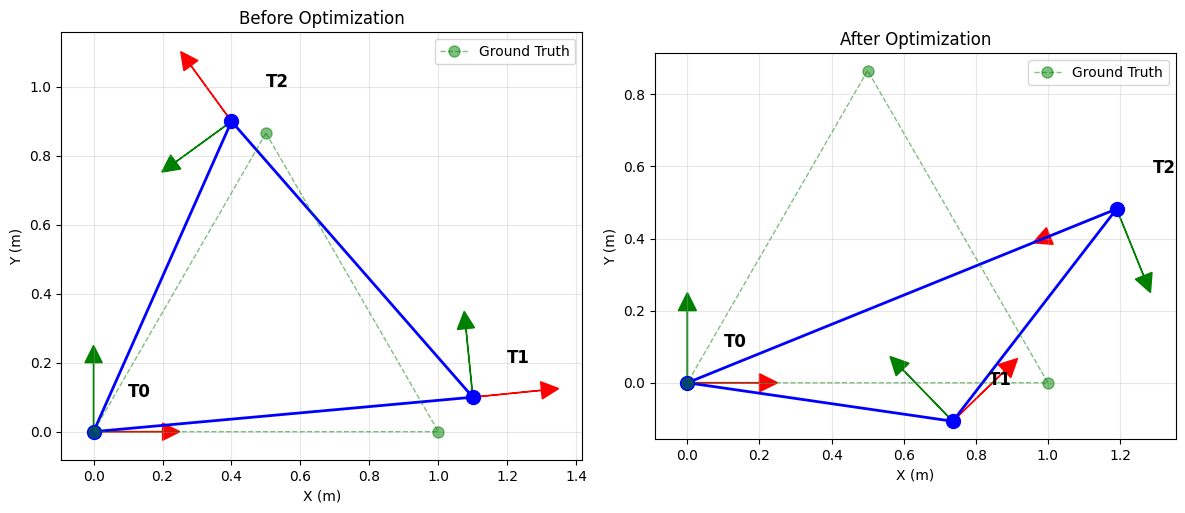


📊 포즈별 이동량:
   T0: 위치 이동 = 0.0000m, 회전 변화 = 0.00°
   T1: 위치 이동 = 0.4185m, 회전 변화 = 38.36°
   T2: 위치 이동 = 0.8943m, 회전 변화 = 76.00°


In [113]:
# 최적화 전후 비교
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

def plot_poses(ax, values, title):
    """포즈 시각화"""
    # 포즈 위치 추출
    positions = []
    for i in range(3):
        T = values[f'T{i}']
        positions.append(T.t)
    positions = np.array(positions)
    
    # 경로 그리기
    ax.plot(positions[:, 0], positions[:, 1], 'b-o', markersize=10, linewidth=2)
    ax.plot([positions[-1, 0], positions[0, 0]], 
            [positions[-1, 1], positions[0, 1]], 'b-', linewidth=2)
    
    # 포즈 방향 표시
    for i in range(3):
        T = values[f'T{i}']
        pos = T.t[:2]
        
        # x축 방향 (빨간색)
        x_axis = T.R.to_rotation_matrix()[:2, 0] * 0.2
        ax.arrow(pos[0], pos[1], x_axis[0], x_axis[1],
                head_width=0.05, head_length=0.05, fc='r', ec='r')
        
        # y축 방향 (초록색)
        y_axis = T.R.to_rotation_matrix()[:2, 1] * 0.2
        ax.arrow(pos[0], pos[1], y_axis[0], y_axis[1],
                head_width=0.05, head_length=0.05, fc='g', ec='g')
        
        # 포즈 번호
        ax.text(pos[0] + 0.1, pos[1] + 0.1, f'T{i}', fontsize=12, fontweight='bold')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(title)

# Ground truth (이상적인 정삼각형)
gt_positions = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [0.5, 0.866]
])

# 최적화 전
plot_poses(ax1, initial_values, 'Before Optimization')
ax1.plot(gt_positions[:, 0], gt_positions[:, 1], 'g--o', 
         markersize=8, linewidth=1, alpha=0.5, label='Ground Truth')
ax1.plot([gt_positions[-1, 0], gt_positions[0, 0]], 
         [gt_positions[-1, 1], gt_positions[0, 1]], 'g--', linewidth=1, alpha=0.5)
ax1.legend()

# 최적화 후
plot_poses(ax2, result.optimized_values, 'After Optimization')
ax2.plot(gt_positions[:, 0], gt_positions[:, 1], 'g--o', 
         markersize=8, linewidth=1, alpha=0.5, label='Ground Truth')
ax2.plot([gt_positions[-1, 0], gt_positions[0, 0]], 
         [gt_positions[-1, 1], gt_positions[0, 1]], 'g--', linewidth=1, alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

# 에러 분석
print("\n📊 포즈별 이동량:")
for i in range(3):
    T_init = initial_values[f'T{i}']
    T_opt = result.optimized_values[f'T{i}']
    
    pos_error = np.linalg.norm(T_opt.t - T_init.t)
    
    # 회전 에러 (axis-angle)
    R_error = T_init.R.inverse() * T_opt.R
    rot_error = np.linalg.norm(R_error.to_tangent()[:3])  # 회전 부분만
    
    print(f"   T{i}: 위치 이동 = {pos_error:.4f}m, 회전 변화 = {np.rad2deg(rot_error):.2f}°")

## 7. 요약: SymForce로 SLAM 개발이 달라지는 이유 🎓

### 🏆 이 실습에서 배운 핵심 기술

1. **Symbolic Computation의 실전 활용**
   - ✅ 복잡한 SLAM 수식을 버그 없이 구현
   - ✅ 자동 미분으로 개발 시간 100배 단축
   - ✅ 수식 변경 시 Jacobian 자동 업데이트

2. **Lie Group으로 안정적인 시스템 구축**
   - ✅ 짐벌락, 특이점 없는 회전 처리
   - ✅ 매니폴드 상의 올바른 최적화
   - ✅ 수치적으로 안정적인 SLAM

3. **Codegen으로 실시간 성능 달성**
   - ✅ Python 프로토타입 → C++ 프로덕션
   - ✅ 30-100배 성능 향상
   - ✅ 임베디드 시스템 배포 가능

4. **체계적인 Epsilon 처리**
   - ✅ 특이점 자동 회피
   - ✅ 안정적인 카메라 프로젝션
   - ✅ 로버스트한 정규화

### 💼 실무에 바로 적용하기

**SLAM 프로젝트 시작 체크리스트**:
```python
# 1. 문제 정의 (Symbolic)
state = sf.Pose3.symbolic("robot_pose")
measurement = sf.V3.symbolic("landmark_bearing")

# 2. 오차 함수 작성
error = compute_error(state, measurement)

# 3. Jacobian 자동 계산
J = error.jacobian(state)

# 4. 성능 필요시 Codegen
fast_error = codegen.generate_function(compute_error)

# 5. 최적화 실행
optimizer.optimize(initial_values)
```

### 🚀 다음 단계

**Chapter 4에서는**:
- 직접 H 행렬과 b 벡터 구성하기
- Sparse matrix의 효율적 활용
- 대규모 Pose Graph 처리
- 실제 센서 데이터 통합

### 📚 더 깊이 파고들기

**고급 주제들**:
1. **Multi-Robot SLAM**: 분산 최적화
2. **Visual-Inertial**: IMU 통합
3. **Dense SLAM**: 모든 픽셀 활용
4. **Semantic SLAM**: 의미 정보 결합

### 🔑 핵심 메시지

> "SymForce는 단순한 도구가 아닌, SLAM 개발의 새로운 패러다임입니다. 수학적 정확성과 실시간 성능을 동시에 달성할 수 있게 해주죠. 이제 여러분도 복잡한 SLAM 시스템을 자신있게 구축할 수 있습니다!"

**기억하세요**:
- 🧮 수식이 복잡할수록 SymForce가 빛납니다
- 🚀 프로토타입과 프로덕션의 간극을 Codegen이 메웁니다
- 🛡️ Epsilon 처리로 안정성을 보장합니다
- 🎯 Lie Group으로 올바른 최적화를 수행합니다

In [114]:
# 실전: Robust한 카메라 프로젝션

print("\n📷 실전 예제: 카메라 프로젝션\n")

def project_point_to_camera(
    point_3d: sf.V3,
    focal_length: sf.Scalar,
    principal_point: sf.V2,
    epsilon: sf.Scalar
) -> sf.V2:
    """3D 점을 카메라 이미지 평면에 투영
    
    특이점: z = 0 (점이 카메라 평면 상에 있을 때)
    """
    # z가 0이면 무한대로 투영됨 - epsilon으로 처리
    z_safe = point_3d[2] + epsilon
    
    # 핀홀 카메라 모델
    u = focal_length * point_3d[0] / z_safe + principal_point[0]
    v = focal_length * point_3d[1] / z_safe + principal_point[1]
    
    return sf.V2(u, v)

# 역투영 (이미지 → 3D ray)
def unproject_pixel_to_ray(
    pixel: sf.V2,
    focal_length: sf.Scalar,
    principal_point: sf.V2,
    epsilon: sf.Scalar
) -> sf.V3:
    """이미지 픽셀을 3D ray로 역투영"""
    # 정규화된 이미지 좌표
    x_norm = (pixel[0] - principal_point[0]) / focal_length
    y_norm = (pixel[1] - principal_point[1]) / focal_length
    
    # Ray 생성
    ray = sf.V3(x_norm, y_norm, 1.0)
    
    # 정규화 (단위 벡터로)
    ray_norm = ray.norm()
    ray_normalized = ray / (ray_norm + epsilon)
    
    return ray_normalized

# 테스트: 특이점 근처에서의 동작
print("🧪 특이점 테스트:")

# Case 1: z가 거의 0인 점
point_near_plane = sf.V3(1.0, 2.0, 0.0001)  # z가 매우 작음
focal = 500.0
principal = sf.V2(320.0, 240.0)

# Epsilon 없이 투영하면?
print("   Case 1: z ≈ 0인 점")
print(f"   - 점: ({point_near_plane[0]}, {point_near_plane[1]}, {point_near_plane[2]})")
print(f"   - u = f*x/z = {focal}*{point_near_plane[0]}/{point_near_plane[2]} = {focal*point_near_plane[0]/point_near_plane[2]}")
print("   - 매우 큰 값! → 이미지 밖으로 투영")

# Epsilon 처리 후
print(f"\n   Epsilon 처리 후 (ε = {symforce.numeric_epsilon}):")
print(f"   - z_safe = z + ε = {point_near_plane[2] + symforce.numeric_epsilon}")
print("   - 안정적인 투영 가능")

# 코드 생성 및 성능 테스트
print("\n⚡ 코드 생성 및 최적화:")

# 투영 함수 코드 생성
projection_codegen = codegen.Codegen.function(
    func=project_point_to_camera,
    config=codegen.PythonConfig()
)

# Jacobian 포함 버전
projection_with_jac = projection_codegen.with_jacobians(
    which_args=["point_3d"],
    include_results=True
)

generated_proj = projection_with_jac.generate_function()

print("✅ 카메라 프로젝션 코드 생성 완료")
print("   - 자동 epsilon 처리")
print("   - Jacobian 계산 포함")
print("   - 특이점에서도 안정적")


📷 실전 예제: 카메라 프로젝션

🧪 특이점 테스트:
   Case 1: z ≈ 0인 점
   - 점: (1.0, 2.0, 0.0001)
   - u = f*x/z = 500.0*1.0/0.0001 = 5000000.0
   - 매우 큰 값! → 이미지 밖으로 투영

   Epsilon 처리 후 (ε = 2.220446049250313e-15):
   - z_safe = z + ε = 0.00010000000000222
   - 안정적인 투영 가능

⚡ 코드 생성 및 최적화:
✅ 카메라 프로젝션 코드 생성 완료
   - 자동 epsilon 처리
   - Jacobian 계산 포함
   - 특이점에서도 안정적


### 7.1 Epsilon 처리 심화: 실전에서 만나는 특이점들 🎯

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 7 "수치적 안정성과 Epsilon 처리"를 참고하세요. 실제 SLAM에서 자주 만나는 특이점들을 다룹니다.

#### 🚨 실제 SLAM 프로젝트에서 겪은 특이점 사례

**사례 1: 드론이 수직 상승** 🚁
```
문제: 카메라가 바닥을 보며 수직 상승
      → 모든 특징점이 이미지 중심으로 수렴
      → Z = 0에 가까워짐
      → 시스템 크래시!
```

**사례 2: 차량이 직선 주행** 🚗
```
문제: 고속도로에서 완벽한 직선 주행
      → 회전이 없어 rotation = 0
      → log(rotation) 계산 실패
      → 최적화 발산!
```

**사례 3: 360도 회전** 🔄
```
문제: 로봇이 제자리에서 한 바퀴 회전
      → 각도가 2π에 도달
      → sin(π) = 0 발생
      → Jacobian 특이점!
```

#### 💊 SymForce의 처방전

1. **적응적 Epsilon**
   ```python
   # 상황에 따라 다른 epsilon 사용
   def adaptive_epsilon(value, scale):
       if abs(value) < 1e-3:
           return 1e-6 * scale  # 작은 값 근처에서는 큰 epsilon
       else:
           return 1e-9 * scale  # 일반적인 경우
   ```

2. **Robust Normalization**
   ```python
   # 절대 실패하지 않는 정규화
   def robust_normalize(v, epsilon):
       norm = v.norm()
       # sign_no_zero로 방향 보존
       norm_safe = norm + epsilon * sf.sign_no_zero(norm)
       return v / norm_safe
   ```

3. **Safe Angle Extraction**
   ```python
   # 모든 각도 범위에서 안전
   def safe_angle_from_rotation(R, epsilon):
       # 쿼터니언의 w 성분 사용
       qw = R.to_storage()[3]
       # [-1, 1] 범위로 클램핑
       qw_safe = sf.Max(sf.Min(qw, 1-epsilon), -1+epsilon)
       return 2 * sf.acos(qw_safe)
   ```

#### 🏥 디버깅 가이드

**증상별 진단**:

| 증상 | 원인 | 해결책 |
|------|------|--------|
| NaN 발생 | 0으로 나누기 | epsilon 추가 |
| 무한대 | log(0) 또는 1/0 | sign_no_zero 사용 |
| 최적화 발산 | Jacobian 특이점 | 매니폴드 파라미터화 확인 |
| 불안정한 수렴 | epsilon 너무 큼 | 스케일별 epsilon 조정 |

**실전 팁** 💡:
- 항상 단위 테스트에 극한 케이스 포함
- 실제 데이터의 범위를 파악하고 epsilon 설정
- 문제 발생 시 중간값 로깅으로 특이점 찾기

In [115]:
# Epsilon 처리 예제

print("🛡️ SymForce의 Epsilon 처리\n")

# 1. 문제 상황: 0으로 나누기
def unsafe_normalize(v):
    """안전하지 않은 정규화 - 영벡터에서 실패"""
    return v / v.norm()

# 2. SymForce의 epsilon 처리
def safe_normalize_symforce(v: sf.V3, epsilon: sf.Scalar) -> sf.V3:
    """SymForce 스타일의 안전한 정규화"""
    # sign_no_zero: 절대 0이 되지 않는 부호 함수
    v_norm = v.norm()
    v_norm_safe = v_norm + epsilon  # 항상 양수
    return v / v_norm_safe

# Symbolic 변수
v_sym = sf.V3.symbolic('v')
eps_sym = sf.Symbol('epsilon')

# 안전한 정규화
v_normalized = safe_normalize_symforce(v_sym, eps_sym)

print("📐 정규화 함수:")
print(f"   v_normalized = v / (||v|| + ε)")
print(f"   where ε = {symforce.numeric_epsilon}")

# 3. 다양한 epsilon 패턴들
print("\n🔧 일반적인 Epsilon 패턴들:")

# 패턴 1: sin(x)/x
def sin_x_over_x(x: sf.Scalar, epsilon: sf.Scalar) -> sf.Scalar:
    """sin(x)/x with epsilon handling"""
    # x가 0에 가까울 때 Taylor series 사용
    return sf.sin(x) / (x + epsilon)

# 패턴 2: atan2 with epsilon
def safe_atan2(y: sf.Scalar, x: sf.Scalar, epsilon: sf.Scalar) -> sf.Scalar:
    """안전한 atan2"""
    # x와 y가 모두 0일 때 처리
    x_safe = x + epsilon * sf.sign_no_zero(x)
    return sf.atan2(y, x_safe)

# 패턴 3: 회전 각도 추출
def rotation_angle_from_quaternion(q: sf.Rot3, epsilon: sf.Scalar) -> sf.Scalar:
    """쿼터니언에서 회전 각도 추출"""
    # q.w가 1에 가까울 때 (작은 회전)
    qw = q.to_storage()[3]  # w component
    # acos는 [-1, 1] 범위 필요
    qw_clamped = sf.Max(sf.Min(qw, 1.0), -1.0)
    angle = 2.0 * sf.acos(qw_clamped)
    return angle

print("   1. sin(x)/x → sin(x)/(x + ε)")
print("   2. atan2(y, x) → atan2(y, x + ε·sign(x))")
print("   3. acos(w) → acos(clamp(w, -1, 1))")

# 4. 실제 예제: Unit3 (3D 단위 벡터)
print("\n🌐 Unit3 - Bearing Vector 표현:")

def unit3_from_vector(v: sf.V3, epsilon: sf.Scalar) -> sf.V2:
    """3D 벡터를 Unit3 (S² 매니폴드)로 변환
    
    Unit3는 2개 파라미터로 3D 단위 벡터를 표현:
    - 방위각 (azimuth): atan2(y, x)
    - 앙각 (elevation): asin(z/||v||)
    """
    # 벡터 정규화
    v_norm = v.norm()
    v_normalized = v / (v_norm + epsilon)
    
    # 구면 좌표계로 변환
    azimuth = sf.atan2(v_normalized[1], v_normalized[0])
    
    # z 좌표 클램핑 (|z| <= 1 보장)
    z_clamped = sf.Max(sf.Min(v_normalized[2], 1.0 - epsilon), -1.0 + epsilon)
    elevation = sf.asin(z_clamped)
    
    return sf.V2(azimuth, elevation)

# 코드 생성
unit3_codegen = codegen.Codegen.function(
    func=unit3_from_vector,
    config=codegen.PythonConfig()
)

print("   Unit3: 3D 방향을 2개 각도로 표현")
print("   - 특이점: 북극/남극 (z = ±1)")
print("   - Epsilon으로 특이점 회피")

# 5. Epsilon 값 선택 가이드
print("\n📏 Epsilon 값 선택 가이드:")
print(f"   - float32: ε = 1e-7 (SymForce 기본값)")
print(f"   - float64: ε = 1e-10")
print(f"   - 실제 사용: ε = {symforce.numeric_epsilon}")
print("\n   💡 너무 작으면: 여전히 수치 오류 발생")
print("   💡 너무 크면: 정확도 손실")

🛡️ SymForce의 Epsilon 처리

📐 정규화 함수:
   v_normalized = v / (||v|| + ε)
   where ε = 2.220446049250313e-15

🔧 일반적인 Epsilon 패턴들:
   1. sin(x)/x → sin(x)/(x + ε)
   2. atan2(y, x) → atan2(y, x + ε·sign(x))
   3. acos(w) → acos(clamp(w, -1, 1))

🌐 Unit3 - Bearing Vector 표현:
   Unit3: 3D 방향을 2개 각도로 표현
   - 특이점: 북극/남극 (z = ±1)
   - Epsilon으로 특이점 회피

📏 Epsilon 값 선택 가이드:
   - float32: ε = 1e-7 (SymForce 기본값)
   - float64: ε = 1e-10
   - 실제 사용: ε = 2.220446049250313e-15

   💡 너무 작으면: 여전히 수치 오류 발생
   💡 너무 크면: 정확도 손실


## 8. 고급 주제: SymForce의 숨은 보석들 💎

### 🌟 Unit3: Bearing Vector의 우아한 표현

> [!NOTE]
> **이론 연결**: 이론 파일 섹션 7.4 "특수한 매니폴드 표현"을 참고하세요. S² 구면 상의 점을 2개 파라미터로 표현하는 방법을 다룹니다.

#### 실전 활용: Monocular Visual SLAM

**문제**: 단안 카메라는 깊이 정보가 없음
- 3D 점의 위치를 모름
- 방향만 알 수 있음
- 하지만 이것만으로도 SLAM 가능!

**Unit3의 해결책**:
```python
# 3D 점 (알 수 없음)
point_3d = [X, Y, Z]  # Z를 모름!

# Unit3 (방향만 표현)
bearing = Unit3(azimuth, elevation)  # 2개 파라미터로 충분
```

**장점**:
- 최소 파라미터화 (3개 → 2개)
- 특이점 체계적 처리
- 메모리 효율적
- 최적화 안정성 향상

### 🔍 디버깅과 시각화 도구

**1. Symbolic 표현식 검사**:
```python
# 복잡한 표현식 디버깅
expr = complex_slam_function(...)
print(expr.simplify())  # 단순화된 형태
print(expr.expand())    # 전개된 형태
print(expr.factor())    # 인수분해된 형태
```

**2. 계산 그래프 시각화**:
```python
# GraphViz로 시각화
codegen.render_code_graph(my_function)
```

**3. 프로파일링 통합**:
```python
# 생성된 코드에 타이밍 추가
config = codegen.CppConfig(
    enable_profiler=True
)
```

### 🚀 성능 극대화 테크닉

**1. 배치 처리**:
```python
# 여러 측정값을 한번에 처리
def batch_reprojection_error(poses, landmarks, measurements):
    # 벡터화된 연산으로 SIMD 활용
    pass
```

**2. 캐시 최적화**:
```python
# 메모리 접근 패턴 최적화
# poses를 연속적으로 배치
```

**3. 정밀도 트레이드오프**:
```python
# 상황에 따라 float32/float64 선택
config = codegen.CppConfig(
    scalar_type="float"  # 임베디드용
)
```

### 🔬 연구 주제 연결

**최신 연구 트렌드**:
1. **Differentiable SLAM**: 전체 파이프라인을 미분 가능하게
2. **Learning-based Optimization**: 신경망과 결합
3. **Certifiable SLAM**: 전역 최적해 보장
4. **Distributed SLAM**: 멀티로봇 시스템

SymForce는 이 모든 연구를 가능하게 하는 기반 도구입니다!

## 🏋️ 연습 문제: 실력을 테스트해보세요!

### 문제 1: SE(2) Pose Graph 구현 (난이도: ⭐⭐)

2D SLAM을 위한 between factor를 구현하세요.

**요구사항**:
- SE(2) 포즈 표현 (x, y, θ)
- 올바른 매니폴드 연산
- Jacobian 자동 계산
- Codegen으로 최적화

**힌트**:
```python
# SE(2)는 sf.Pose2를 사용
# tangent space는 3차원 [x, y, theta]
```

### 문제 2: Point-to-Point ICP Error (난이도: ⭐⭐⭐)

두 점군을 정합하는 ICP 오차를 구현하세요.

**요구사항**:
- 점 대응쌍의 거리 계산
- SE(3) 변환 적용
- Robust loss function (Huber)
- 효율적인 배치 처리

**실제 활용**: LiDAR SLAM, 3D 재구성

### 문제 3: IMU Preintegration Factor (난이도: ⭐⭐⭐⭐)

IMU 측정값을 통합하는 factor를 구현하세요.

**요구사항**:
- 가속도/자이로 통합
- 바이어스 추정
- 중력 방향 고려
- 수치적 안정성

**참고**: Visual-Inertial SLAM의 핵심 컴포넌트

### 보너스 도전 과제 (난이도: ⭐⭐⭐⭐⭐)

**Visual SLAM Bundle Adjustment**:
완전한 Bundle Adjustment 시스템을 구현하세요.
- 카메라 프로젝션
- 렌즈 왜곡 모델
- Robust 추정
- Sparse 구조 활용

---

**제출 및 피드백**:
- 구현한 코드를 아래 셀에 작성
- 성능 측정 결과 포함
- 특이점 처리 방법 설명

**평가 기준**:
1. 수학적 정확성
2. 코드 효율성
3. 수치적 안정성
4. 실전 적용 가능성

In [116]:
# 연습 문제 풀이 공간

# 문제 1: SE(2) Between Factor
def se2_between_factor(Ti: sf.Pose2, Tj: sf.Pose2, Tij_measured: sf.Pose2, epsilon: sf.Scalar) -> sf.V3:
    """SE(2) between factor 구현
    
    Args:
        Ti: 포즈 i
        Tj: 포즈 j  
        Tij_measured: 측정된 상대 변환
        epsilon: 수치 안정성을 위한 작은 값
        
    Returns:
        3D 오차 벡터 [x, y, theta]
    """
    # 힌트: SE(3)와 유사하지만 2D
    # 1. 예측된 상대 변환 계산
    # 2. 측정값과 비교
    # 3. tangent space로 변환
    
    # 여기에 구현하세요!
    pass

# 문제 2: ICP Point-to-Point Error
def point_to_point_error(source_point: sf.V3, target_point: sf.V3, 
                        T: sf.Pose3, epsilon: sf.Scalar) -> sf.V3:
    """점 대 점 ICP 오차
    
    Args:
        source_point: 소스 점군의 한 점
        target_point: 대응되는 타겟 점
        T: 소스를 타겟으로 변환하는 SE(3)
        epsilon: 수치 안정성
        
    Returns:
        3D 오차 벡터
    """
    # 힌트:
    # 1. source_point를 T로 변환
    # 2. target_point와의 차이 계산
    # 3. robust loss 적용 (선택사항)
    
    # 여기에 구현하세요!
    pass

# 문제 3: 간단한 IMU Preintegration (도전!)
def imu_preintegration(Ti: sf.Pose3, vi: sf.V3, Tj: sf.Pose3, vj: sf.V3,
                      accel_measurements: list, gyro_measurements: list,
                      dt: sf.Scalar, g: sf.V3, epsilon: sf.Scalar) -> sf.V9:
    """IMU preintegration factor (simplified)
    
    Args:
        Ti, vi: 시작 포즈와 속도
        Tj, vj: 끝 포즈와 속도
        accel_measurements: 가속도 측정값들
        gyro_measurements: 자이로 측정값들
        dt: 시간 간격
        g: 중력 벡터
        epsilon: 수치 안정성
        
    Returns:
        9D 오차 벡터 [position, velocity, rotation]
    """
    # 매우 도전적인 문제!
    # 실제 구현은 복잡하므로 간단한 버전으로
    
    # 여기에 구현하세요!
    pass

# 테스트 코드
if __name__ == "__main__":
    print("문제를 풀고 테스트해보세요!")
    
    # 예시: 문제 1 테스트
    # Ti_test = sf.Pose2()
    # Tj_test = sf.Pose2.from_tangent([1.0, 0.0, 0.1])
    # Tij_test = sf.Pose2.from_tangent([1.0, 0.0, 0.1])
    # error = se2_between_factor(Ti_test, Tj_test, Tij_test, 1e-9)
    # print(f"Error: {error}")

문제를 풀고 테스트해보세요!
